# Getting main cluster

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [5]:
df = pd.read_parquet('../data/geocoded_stock.parquet')
df

,suite_area,street,neighborhood,condominium,tax,asking_price,full_address,latitude,longitude
0,70,Rua Lamute,"São João Clímaco, São Paulo",0,59,15.714286,"Rua Lamute, São João Clímaco, São Paulo",-23.625642,-46.591113
3,33,Rua Luís Correia de Melo,"Santo Amaro, São Paulo",506,91,81.818182,"Rua Luís Correia de Melo, Santo Amaro, São Paulo",-23.633037,-46.715464
4,104,Rua Jorge Rizzo,"Pinheiros, São Paulo",1680,0,53.846154,"Rua Jorge Rizzo, Pinheiros, São Paulo",-23.571447,-46.696173
5,50,Rua Barata Ribeiro,"Bela Vista, São Paulo",572,207,57.000000,"Rua Barata Ribeiro, Bela Vista, São Paulo",-23.556436,-46.653009
8,52,Rua Dom Vilares,"Vila das Mercês, São Paulo",657,11,61.538462,"Rua Dom Vilares, Vila das Mercês, São Paulo",-23.624632,-46.607442
...,...,...,...,...,...,...,...,...,...
2273,26,Avenida Nove de Julho,"Bela Vista, São Paulo",270,0,89.230769,"Avenida Nove de Julho, Bela Vista, São Paulo",-23.553233,-46.648014
2277,75,Rua Gaspar Lourenço,"Vila Mariana, São Paulo",1750,463,44.280000,"Rua Gaspar Lourenço, Vila Mariana, São Paulo",-23.582562,-46.630790
2283,64,Rua Doutor Albuquerque Lins,"Santa Cecília, São Paulo",900,6,43.750000,"Rua Doutor Albuquerque Lins, Santa Cecília, Sã...",-23.539111,-46.657958
2286,49,Rua dos Jacintos,"Mirandópolis, São Paulo",512,181,75.510204,"Rua dos Jacintos, Mirandópolis, São Paulo",-23.604972,-46.639829


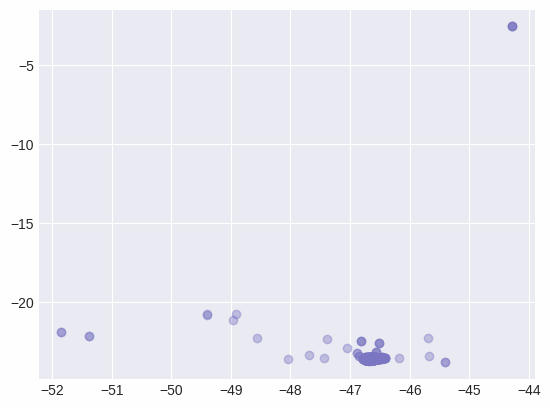

In [6]:
plt.scatter(df.longitude, df.latitude, alpha=0.4);

Podemos ver que existem outliers na localizaçao dos conjuntos disponiveis para alugar. Entao usaremos o metodo de clusterizaçao por densidade DBSCAN para selecionar um cluster principal

In [7]:
db = DBSCAN(eps=0.1, min_samples=10).fit(df[['longitude', 'latitude']])

df['cluster'] = db.labels_

n_clusters_ = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise_ = list(df['cluster']).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 2
Estimated number of noise points: 36


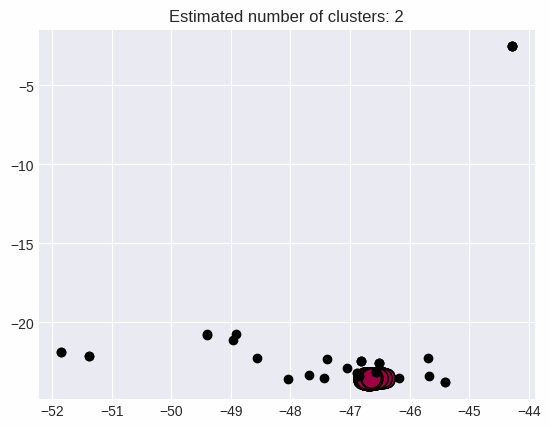

In [8]:
unique_labels = set(df['cluster'])
core_samples_mask = np.zeros_like(df['cluster'], dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		col = [0, 0, 0, 1]

	class_member_mask = df['cluster'] == k

	xy = df[class_member_mask & core_samples_mask]
	plt.plot(
		xy['longitude'],
		xy['latitude'],
		"o",
		markerfacecolor=tuple(col),
		markeredgecolor="k",
		markersize=14,
	)

	xy = df[class_member_mask & ~core_samples_mask]
	plt.plot(
		xy['longitude'],
		xy['latitude'],
		"o",
		markerfacecolor=tuple(col),
		markeredgecolor="k",
		markersize=6,
	)

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

<Axes: xlabel='cluster', ylabel='asking_price'>

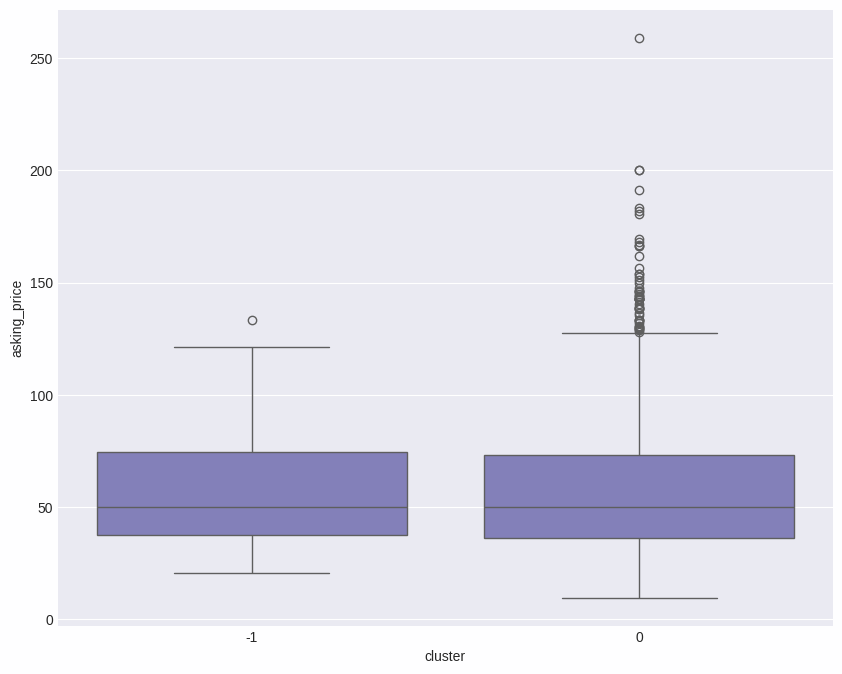

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='cluster', y='asking_price', data=df)

In [10]:
df[df.cluster == 0].describe()

,suite_area,condominium,tax,asking_price,latitude,longitude,cluster
count,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.0
mean,52.607338,544.350507,86.399688,58.764095,-23.561087,-46.633044,0.0
std,31.727545,455.643468,157.316901,32.125901,0.043179,0.063484,0.0
min,12.000000,0.000000,0.000000,9.444444,-23.688078,-46.788418,0.0
25%,33.000000,295.000000,0.000000,36.140000,-23.593103,-46.674335,0.0
50%,45.000000,480.000000,44.000000,50.000000,-23.555833,-46.639829,0.0
75%,63.000000,719.000000,108.000000,72.833333,-23.535294,-46.605657,0.0
max,342.000000,4800.000000,2250.000000,259.259259,-23.444893,-46.416320,0.0


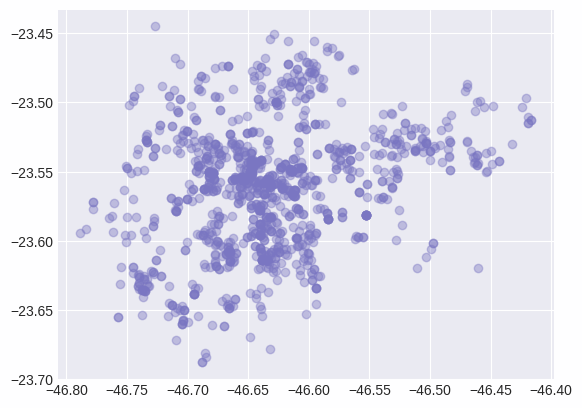

In [11]:
plt.scatter(df[df.cluster == 0].longitude, df[df.cluster == 0].latitude, alpha=0.4);

agora a distribuiçao geografica dos conjuntos esta mais interessante para uma analise

In [12]:
df[df.cluster == 0].drop('cluster', axis=1).to_parquet('../data/main_cluster.parquet')